---

# Задание 1

1. Загрузите данные из файла ***данные для кластеризации.xlsx*** (находится в папке datasets).
2. Метки класса из столбца *Office* присвойте вектору *y*, остальные данные для кластеризации присвойте матрице *X*.
3. Нормализуйте данные матрицы X.
4. Импортируйте метод ***KMeans***.
5. Проведите анализ на количество кластеров с помощью метода локтя, а так же на основе метрик *silhouette_score*, *calinski_harabasz_score* и *davies_bouldin_score*. 
6. Сделайте выводы по результатам анализа.
7. Обучите модель *KMeans* с разбиением на два кластера.
8. Оцените результат с помощью *classification_report()*, сравнив попадание объектов в кластеры с реальными классами объектов из исходного файла с данными. Имейте в виду, что кластеры - это не классы, поэтому важно то, что одни и те же объекты попали внутрь одной группы, а не то, какой номер группы им присвоен моделью. На протяжении всех заданий мы будем оценивать качество кластеризации, сравнивая кластеры с классификацией данных по признакам: Rain и Office.
9. Оцените результат кластеризации с помощью функции *metrics4()* и заполните соответствующий столбец таблицы итогов кластеризации *m4*.
10. Сделайте выводы по результатам оценки качества кластеризации.

---

***Рекомендации:***

1. При проведении анализа на количество кластеров выбирайте верхнюю границу диапазона не меньше 100 (для метода локтя 50).
2. Не забывайте, что модель может нумеровать кластеры не в том порядке, как в данных.

# РЕШЕНИЕ ЗАДАНИЯ 1

In [10]:
# Начало работы

# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import pylab
import seaborn as sns
#plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (21, 14)
import itertools
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Сброс ограничений на число выводимых столбцов
pd.set_option('display.max_columns', None)

# Подключение гугл-диска
from google.colab import drive 
drive.mount('/content/drive')

# Загрузка данных
data = pd.read_excel('/content/drive/MyDrive/Pyton/данные_для_кластеризации.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Функции, которые пригодятся нам при решении задания

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Функция, которая строит график ошибок классификации TP, FP, TN, FN. Она нам понадобится
    для оценки качества кластеризации при сравнении кластеров с классами"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        thresh = 0.5   
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Class label')
    plt.xlabel('Cluster label')
    
def plot_dendrogram(model, **kwargs):
    """Функция, которая принимает модель агломеративной кластеризации и строит
    дендрограмму исследуемых данных"""
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    hierarchy.dendrogram(linkage_matrix, **kwargs)

def metrics4(X, labels, y):
    """Функция, которая вычисляет различные метрики, которые мы будем использовать
    для оценки качества кластеризации. Здесь у - это колонка с реальными метками
    классов датасета"""
    result = [adjusted_rand_score(y, labels)]
    result.append(silhouette_score(X, labels, random_state=21))
    result.append(calinski_harabasz_score(X, labels))
    result.append(davies_bouldin_score(X, labels))
    return result

m4 = pd.DataFrame(index = ['adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 
                           'davies_bouldin_score'])

In [12]:
data

,weekday_sin,weekday_cos,Order_bac_sin,Order_bac_cos,Delivery_time_norm,Rain,Office
0,0.974928,-0.222521,6.609058e-02,0.997814,0.508994,1,1
1,0.974928,-0.222521,6.609058e-02,0.997814,-0.973604,1,1
2,0.974928,-0.222521,6.609058e-02,0.997814,2.584630,1,1
3,0.974928,-0.222521,6.609058e-02,0.997814,1.102033,1,0
4,0.974928,-0.222521,1.318922e-01,0.991264,0.212474,1,1
...,...,...,...,...,...,...,...
20786,-0.781831,0.623490,-1.318922e-01,0.991264,-1.270124,1,1
20787,-0.781831,0.623490,-6.609058e-02,0.997814,0.508994,1,1
20788,-0.781831,0.623490,-6.609058e-02,0.997814,0.212474,1,1
20789,-0.781831,0.623490,-2.449294e-16,1.000000,0.212474,1,1


In [13]:
y = data.Office
X = data.iloc[:, : - 1]
X

,weekday_sin,weekday_cos,Order_bac_sin,Order_bac_cos,Delivery_time_norm,Rain
0,0.974928,-0.222521,6.609058e-02,0.997814,0.508994,1
1,0.974928,-0.222521,6.609058e-02,0.997814,-0.973604,1
2,0.974928,-0.222521,6.609058e-02,0.997814,2.584630,1
3,0.974928,-0.222521,6.609058e-02,0.997814,1.102033,1
4,0.974928,-0.222521,1.318922e-01,0.991264,0.212474,1
...,...,...,...,...,...,...
20786,-0.781831,0.623490,-1.318922e-01,0.991264,-1.270124,1
20787,-0.781831,0.623490,-6.609058e-02,0.997814,0.508994,1
20788,-0.781831,0.623490,-6.609058e-02,0.997814,0.212474,1
20789,-0.781831,0.623490,-2.449294e-16,1.000000,0.212474,1


In [14]:
# Нормализуем данные

sc = StandardScaler()
sc.fit(X)  # найти мат. ожидание и дисперсия
X = sc.transform(X) # нормализовать так, чтобы мат. ожидание Е = 0 дисперсия  D = 1

In [15]:
# Импортируем метод к-средних (K-Means)

from sklearn.cluster import KMeans

## Применим методы для определения количества кластеров

### Метод локтя

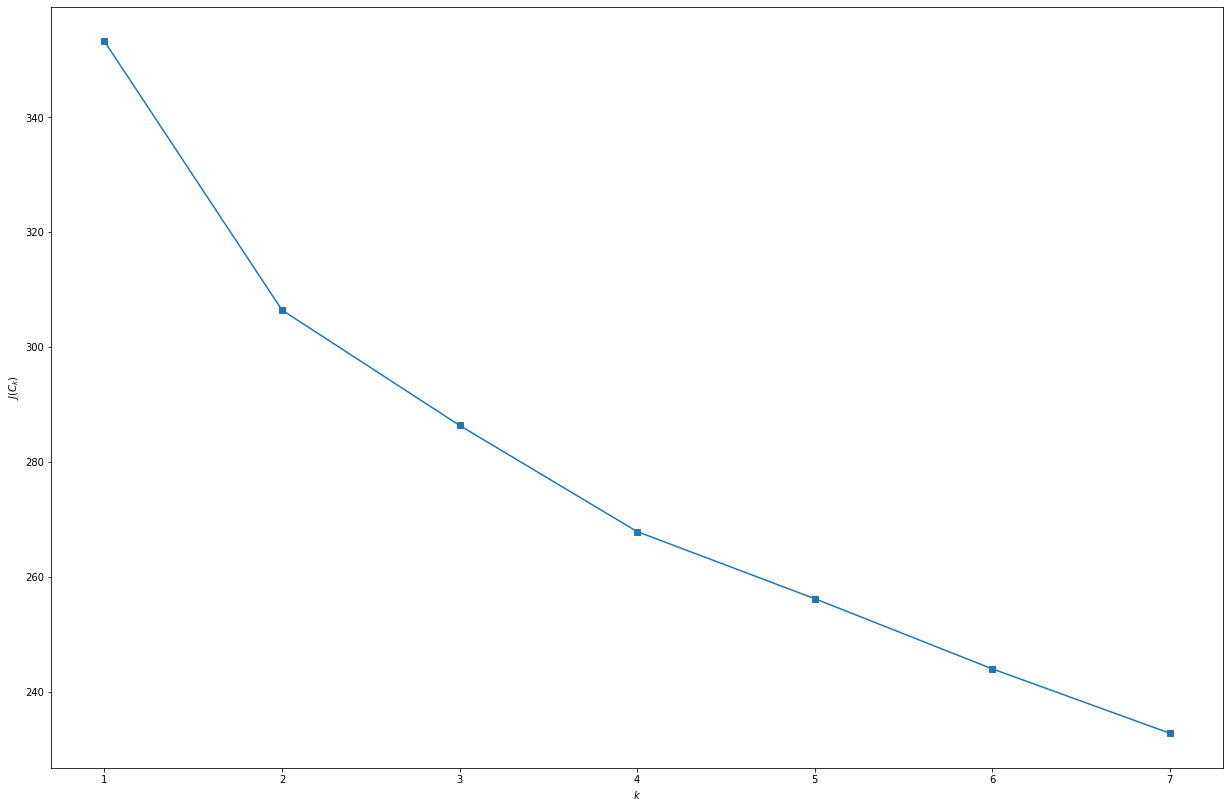

In [16]:
# Применим метод локтя
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=21).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

# построим график
plt.plot(range(1, 8), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.show()

 Выбирается то количество кластеров, при котором метрика резко уменьшает свое снижение (локоть).
 
 Метод локтя явно ничего не показывает

### Метод silhouette_score

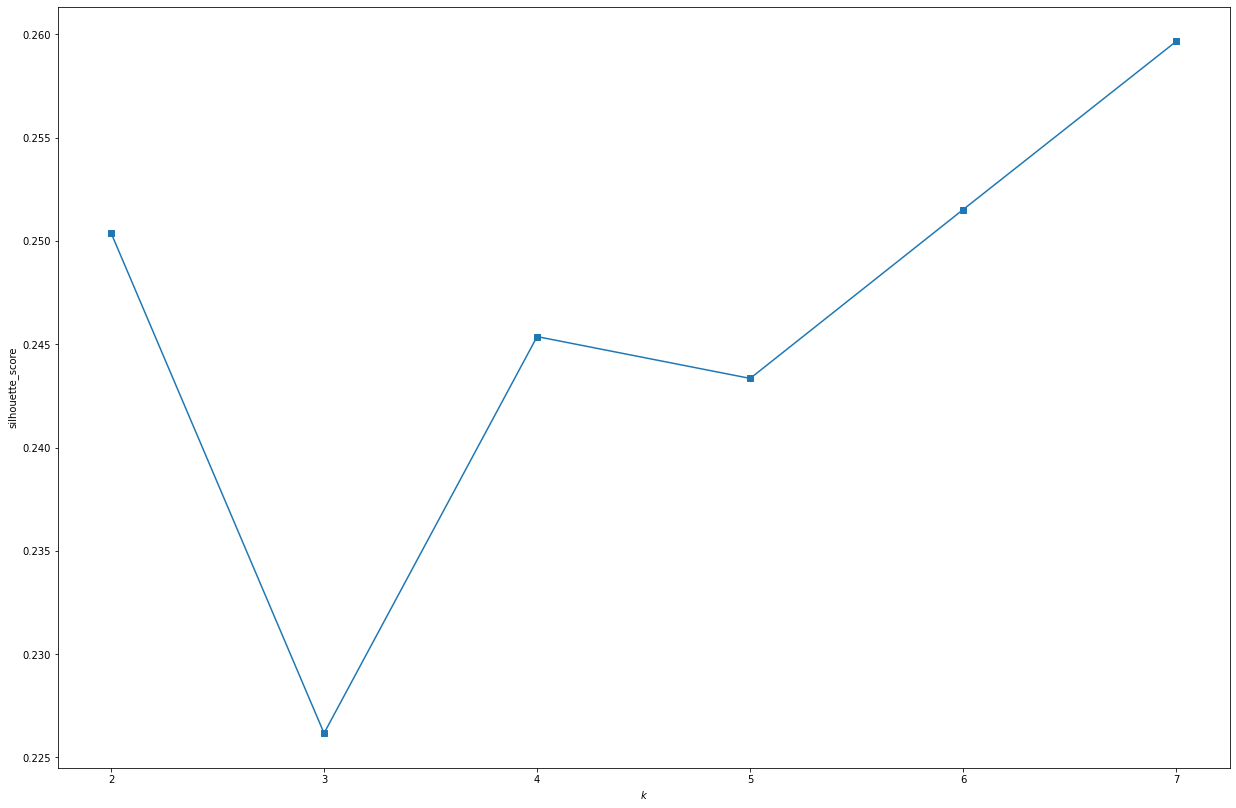

In [17]:
# Применим метод силуета silhouette_score

from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    silhouette.append(silhouette_score(X, km.labels_, random_state=21))

# построим график
plt.plot(range(2, 8), silhouette, marker='s')
plt.xlabel('$k$')
plt.ylabel('silhouette_score')
plt.show()

Близость silhouette_score к 1 говорит об идеальном разбиении на кластеры, к -1 - к идеально плохому разбиению.

Метод силуэта явно ничего не показывает, но если рассматривать количество кластеров меньше 5, то кластеров 2

### Метод Калински-Харабаса (calinski_harabasz_score)

4512.589605926481


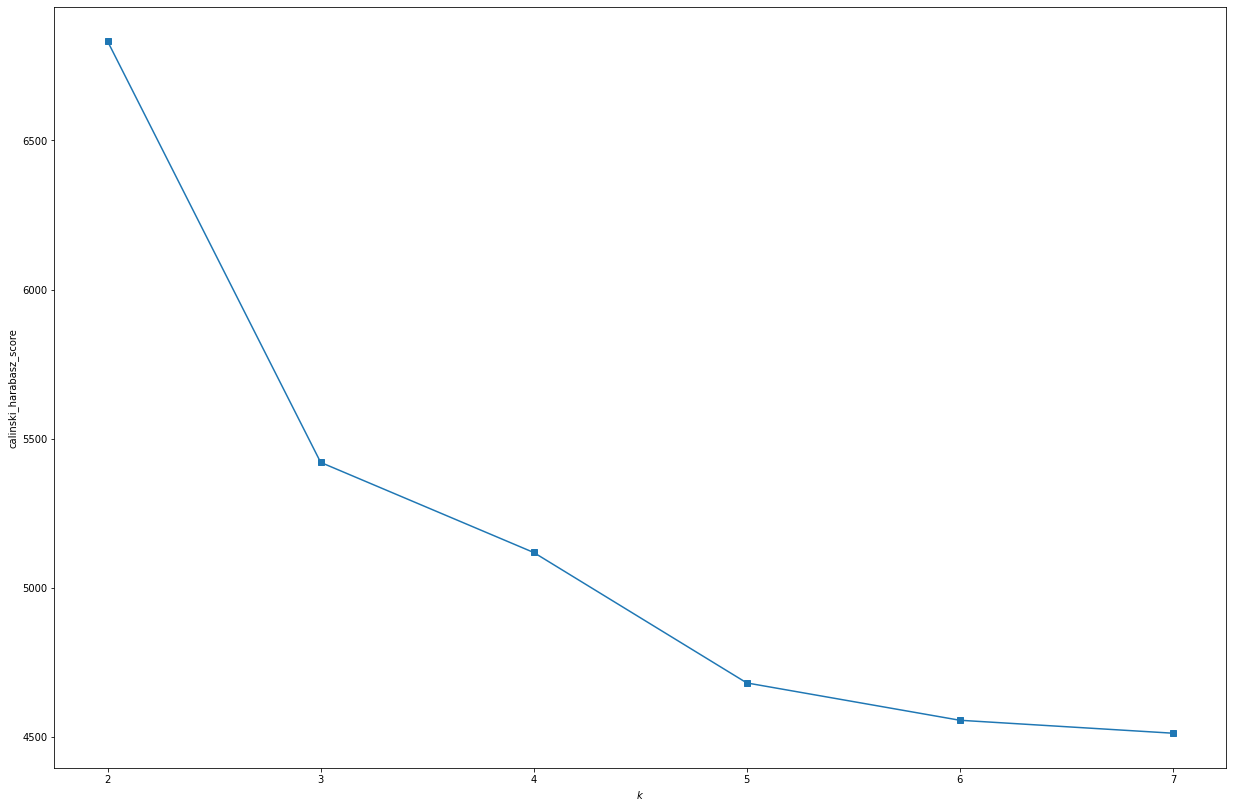

In [18]:
# Применим метод calinski_harabasz_score

from sklearn.metrics import calinski_harabasz_score

print(calinski_harabasz_score(X, kmeans.labels_))

ch = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    ch.append(calinski_harabasz_score(X, km.labels_))

plt.plot(range(2, 8), ch, marker='s')
plt.xlabel('$k$')
plt.ylabel('calinski_harabasz_score')
plt.show()

Метод Калински-Харабаса показывает отношение дисперсии объектов внутри кластера и дисперсии между кластерами.

Метод Калински-Харабаса показывает, что кластеров 2

### Метод Девиса Болдина (davies_bouldin_score)

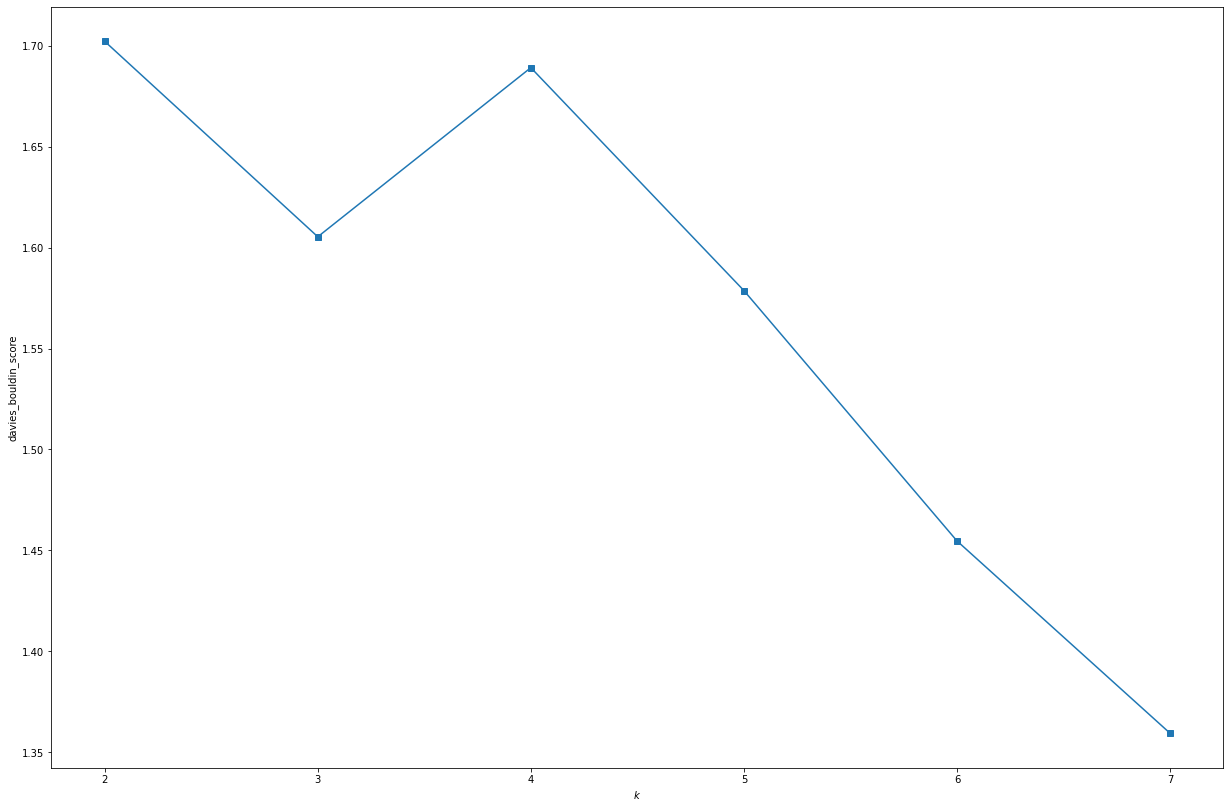

In [19]:
# Применим метод davies_bouldin_score

from sklearn.metrics import davies_bouldin_score

db = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    db.append(davies_bouldin_score(X, km.labels_))

plt.plot(range(2, 8), db, marker='s')
plt.xlabel('$k$')
plt.ylabel('davies_bouldin_score')
plt.show()

Метод Девиса Болдина оценивает близость объектов внутри кластера и удаленность от других кластеров. Чем ближе значение метрики к нулю - тем лучше.
 
Метод Девиса Болдина не дает однозначного ответа для количества кластеров. Но если  мы рассматриваем количество кластеров меньше пяти, то ответ - 3

Общий вывод. Большинство методов определения количества кластеров дали нам ответ - 2

## Обучим модель

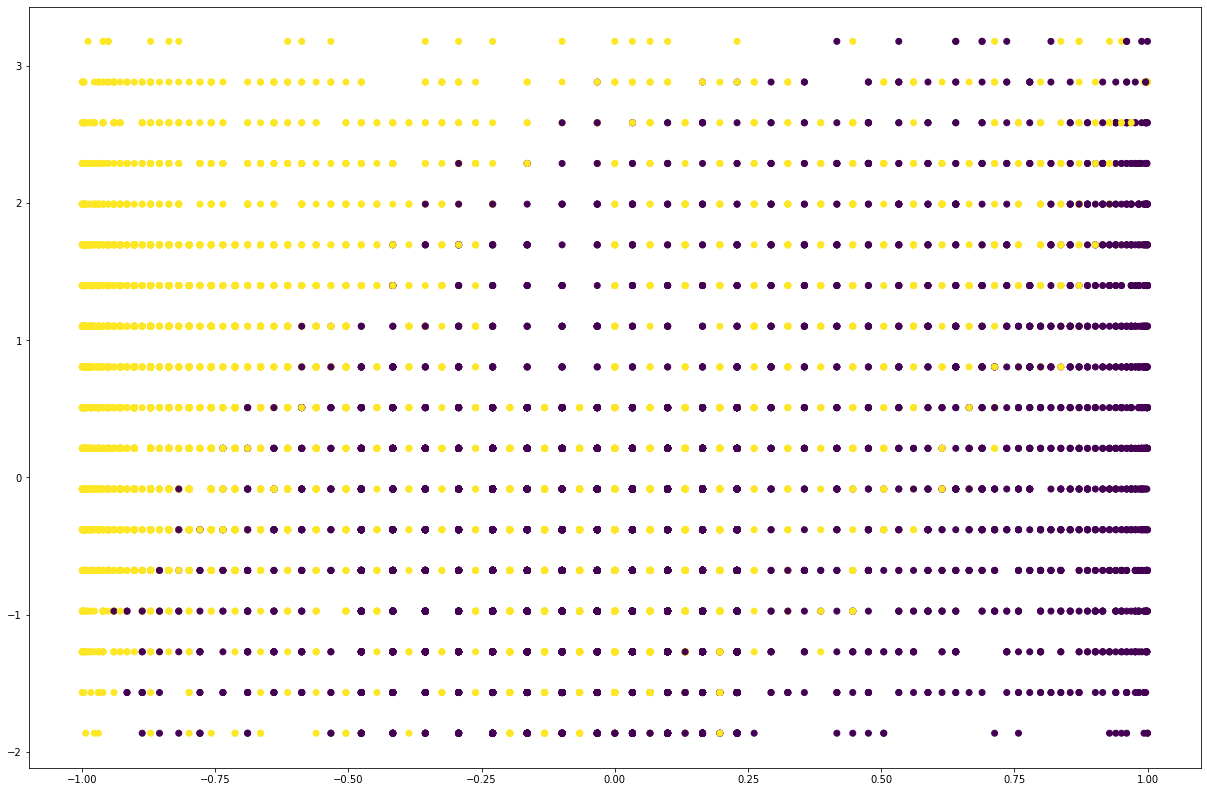

In [20]:
# Обучим модель K-Means

kmeans = KMeans(n_clusters=2, random_state=21).fit(X)

# Построим график
plt.scatter(data.Order_bac_sin, data.Delivery_time_norm , c=kmeans.labels_)
plt.show()

In [21]:
# Посмотрим на значение метрик

y_pred = kmeans.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.15      0.14      9389
           1       0.21      0.19      0.20     11402

    accuracy                           0.17     20791
   macro avg       0.17      0.17      0.17     20791
weighted avg       0.18      0.17      0.17     20791



Метрики получились очень плохие. Возможно, это из-за несовпадения нумерации класса и кластера

In [22]:
# Сравним нумерацию классов и кластеров

for j in range(kmeans.labels_.max()+1):
    print('метка класса =', j, '   метка кластера =', kmeans.labels_[y==j].mean(), 
          '   стандартное отклонение меток кластера =', kmeans.labels_[y==j].std())

метка класса = 0    метка кластера = 0.8466290339759293    стандартное отклонение меток кластера = 0.3603447138573203
метка класса = 1    метка кластера = 0.18601999649184353    стандартное отклонение меток кластера = 0.38912280503334423


Делаем вывод, что номера классов перепутаны. Изменим.

In [23]:
y_pred = 1 - y_pred

In [24]:
kmeans.labels_ = 1 - kmeans.labels_

In [25]:
# Посмотрим на значение метрик

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      9389
           1       0.87      0.81      0.84     11402

    accuracy                           0.83     20791
   macro avg       0.83      0.83      0.83     20791
weighted avg       0.83      0.83      0.83     20791



Получилось неплохая кластеризация.

In [26]:
def metrics4(X, labels, y):
    result = [adjusted_rand_score(y, labels)]
    result.append(silhouette_score(X, labels, random_state=21))
    result.append(calinski_harabasz_score(X, labels))
    result.append(davies_bouldin_score(X, labels))
    return result

m4 = pd.DataFrame(index = ['adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 
                           'davies_bouldin_score'])
m4['KMeans'] = metrics4(X, kmeans.labels_, y)
m4

,KMeans
adjusted_rand_score,0.432206
silhouette_score,0.250400
calinski_harabasz_score,6832.006453
davies_bouldin_score,1.702163


---

## Агломеративный метод

Агломеративный метод - один из методов иерархической кластеризации. Иерархическая кластеризация позволяет получить не просто разбиение на кластеры, а целую иерархию вложенных кластеров. Агломеративный метод изначально считает каждый объект отдельным классом, затем на каждом шаге он начинает объединять попарно ближайшие классы. Алгоритм прекращает работу, когда все объекты объединены в один класс.

Достоинства метода:
1. В результате имеем иерархию возможных разбиений на кластеры.
2. Удобная визуализация результатов в виде дендрограммы.

Недостатки метода:
1. Требует большие объемы памяти компьютера.
2. Медленно работает при больших объемах данных.

---

Ипортируем агломеративный методод [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) и [hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) от куда нам понадобится функция [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) для визуализации дендрограммы.

---

# Задание 2

1. Обучите общую модель агломеративной кластеризации.
2. Сделайте вывод о количестве кластеров в данных на основе дендрограммы.
3. Обучите модель агломеративной кластеризации для двух кластеров.
4. Оцените качество кластеризации и запишите результаты в таблицу.
5. Сделайте выводы о результатах кластеризации.

---

# РЕШЕНИЕ ЗАДАНИЯ 2

In [27]:
# Ипортируем агломеративный методод

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

In [28]:
# Функция для дендрограммы

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    hierarchy.dendrogram(linkage_matrix, **kwargs)

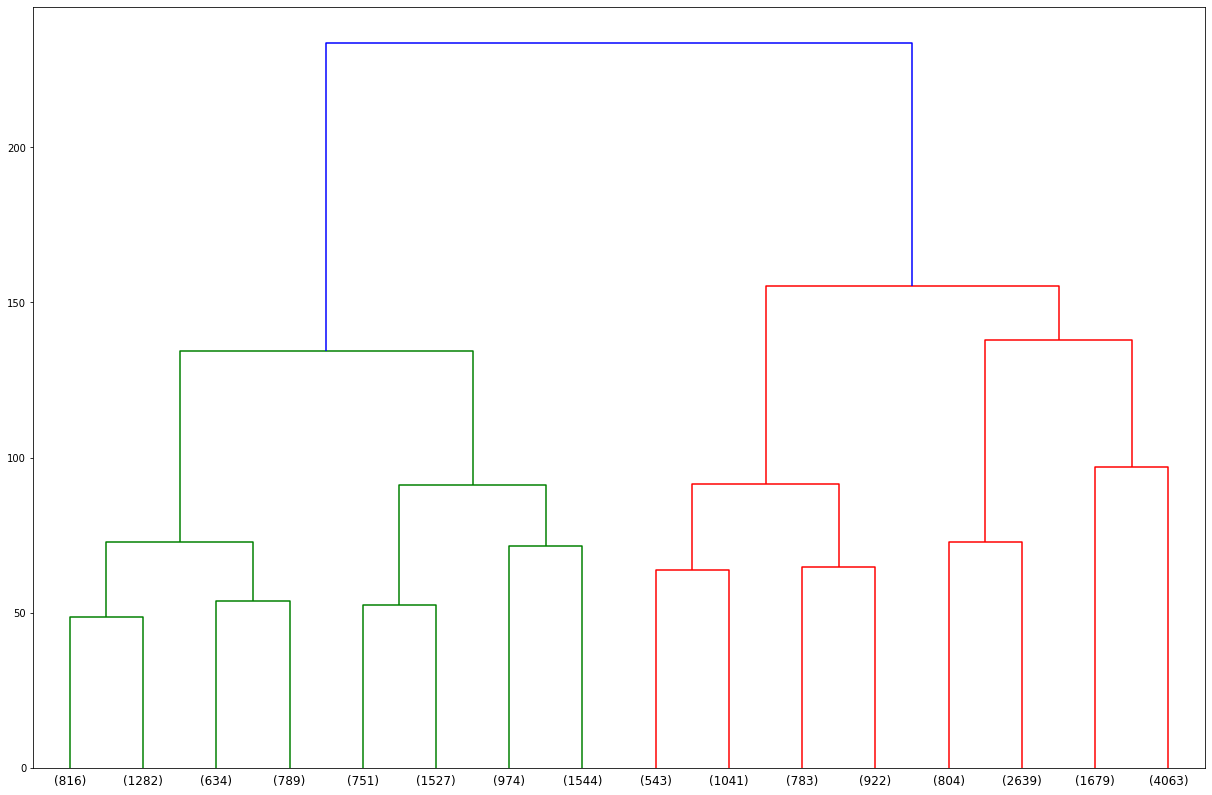

In [29]:
# Обучим общую модель агломеративной кластеризации и построим дендрограмму
    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)
plot_dendrogram(model, truncate_mode='level', p=3)

Количество кластеров в данных можно определить на основе дендрограммы - большие расстояния между кластерами и их объединением (ось ординат) свидетельствуют о различных кластерах. Анализируя полученную дендрограмму можно сделать вывод о наличии двух кластеров.

In [30]:
# Обучим модель агломеративной кластеризации для двух кластеров   

model_2 = AgglomerativeClustering(n_clusters=2).fit(X)
print(classification_report(y, model_2.labels_))

              precision    recall  f1-score   support

           0       0.14      0.19      0.16      9389
           1       0.08      0.06      0.07     11402

    accuracy                           0.12     20791
   macro avg       0.11      0.12      0.11     20791
weighted avg       0.11      0.12      0.11     20791



In [31]:
# Сравним нумерацию классов и кластеров

for j in range(model_2.labels_.max()+1):
    print('метка класса =', j, '   метка кластера =', model_2.labels_[y==j].mean(), 
          '   стандартное отклонение меток кластера =', model_2.labels_[y==j].std())

метка класса = 0    метка кластера = 0.8143572265416977    стандартное отклонение меток кластера = 0.3888181247331607
метка класса = 1    метка кластера = 0.05884932467988072    стандартное отклонение меток кластера = 0.2353424773911474


Получается, что классу с меткой 0 соответствует кластер с меткой 1 и наоборот. Исправим.

In [32]:
# Поменяем метки

model_2.labels_ = 1 - model_2.labels_

In [33]:
# Посмотрим результат

y_ac = np.full(y.shape, fill_value=np.nan)
for j in range(4):
     y_ac[y == j] = round(model_2.labels_[y==j].mean(), 0)
print(classification_report(y, model_2.labels_))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      9389
           1       0.86      0.94      0.90     11402

    accuracy                           0.88     20791
   macro avg       0.89      0.88      0.88     20791
weighted avg       0.89      0.88      0.88     20791



88% объектов классов угаданы при кластеризации.

Подсчитаем и запишем в таблицу метрики качества кластеризации:

In [34]:
m4['AgglomerativeClustering'] = metrics4(X, model_2.labels_, y_ac)
m4

,KMeans,AgglomerativeClustering
adjusted_rand_score,0.432206,0.589320
silhouette_score,0.250400,0.223899
calinski_harabasz_score,6832.006453,5819.019760
davies_bouldin_score,1.702163,1.787194


## Метод главных компонент

Метод главных компонент [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) позволяет с помощью линейных преобразований исходных признаков перейти в новое признаковое пространство. В результате преобразований появляется возможность снизить количество признаков при минимальной потере дисперсии. Количество главных компонент опеределяется исследователем на основании требования к сохраненной дисперсии. Обычно ориентируются на 90% дисперсии, но, исходя из конкретики задачи, требование к сохраненной дисперии может быть и больше и меньше. Например, при сильном шуме в данных, требование к сохраненной дисперсии может быть значительно ниже 90%. Порог сохраненной дисперсии может определяться эксперементально, на основе качества решения итоговой задачи.

Достоинства метода главных компонент:
1. Главные компоненты ортогональны друг другу, что позволяет решить проблему мультиколлинеарности признаков.
2. В случае большого количества исходных признаков, позволяет снизить вычислительную нагрузку в задачах классификации и регресии с незначительной потерей качества результата.
3. За счет отбрасывания части главных компонент, позволяет снизить шум в данных, что снижает эффект переобучения моделей.

Недостатки метода:
1. Плохо работает в случае низкой корреляции среди исходных признаков.
2. Плохо работает для визуализации многомерных пространств признаков на плоскости.

---

# Задание 3

1. Обучить модель для 6 главных компонент.
2. Визуализировать сохраненную дисперсию.
3. Определить количество главных компонент, сохраняющих не менее 90% дисперсии.
4. Обучить модель для двух главных компонент и визуализировать данные.
5. Сделать выводы об эффективности применения метода главных компонент к решаемой задаче. По какому признаку можно разделить выборку на кластеры?

# РЕШЕНИЕ ЗАДАНИЯ 3

In [35]:
from sklearn.decomposition import PCA

In [36]:
# Обучим модель для 6 главных компонент

pca = PCA(n_components=6, random_state=21)
X1 = data.iloc[:, : - 1]
X_centered = X1 - X1.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

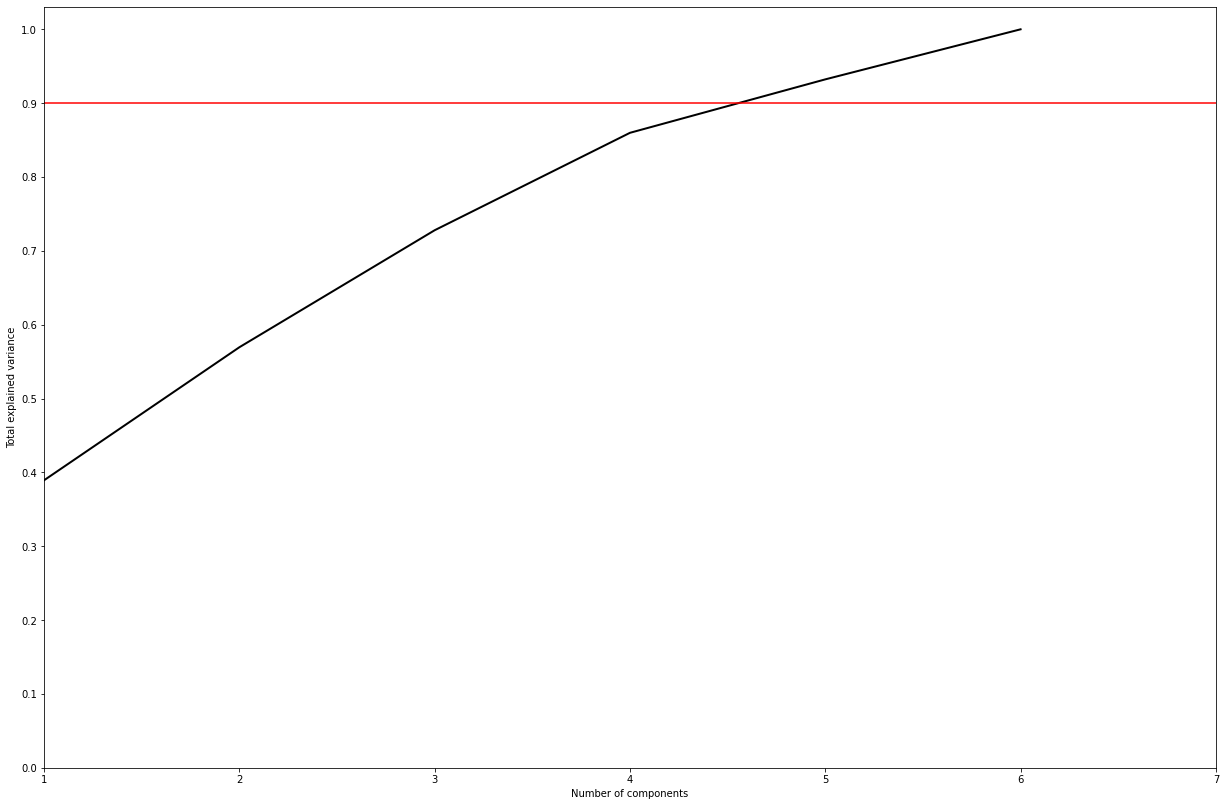

In [37]:
# Визуализируем сохраненную дисперсию

plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(1, 7)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show()

Количество главных компонент, сохраняющих не менее 90% дисперсии - 5.

In [38]:
# Обучим модель для 2 главных компонент

pca = PCA(n_components=2, random_state=21)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

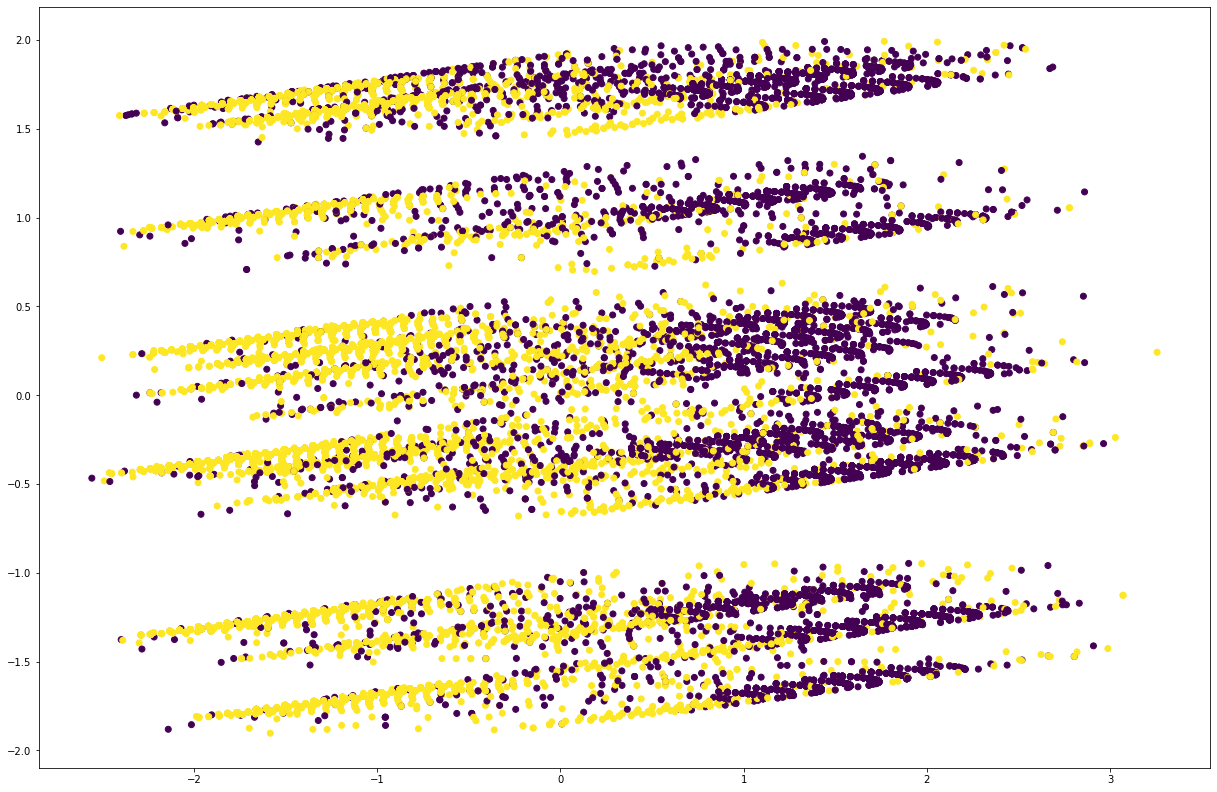

In [39]:
# Визуализируем данные

pca = PCA(n_components=2, random_state=21)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()

Вывод. Имеет смысл брать пять главных компонент.

---

## t-SNE

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - еще один метод снижения размерности. В отличие от метода главных компонент, t-SNE сжимает данные таким образом, чтобы сохранить их структуру. При этом полученное расстояние в сжатом признаковом в пространстве скорее всего никак не будет соотносится с расстояниями в исходном признаковом в пространстве. Метод пытается перенести окрестность каждой точки из исходного пространства в сжатое. 

Достоинства метода:
1. Метод прост в применении.
2. Работает с большими объемами данных.
3. Эффективен при визуализации на плоскости многомерных данных.

Недостатки метода:
1. Полученные результаты практически не интерпретируются.
2. Может найти структуру в абсолютном шуме.

---

# Задание 4

Визуализируйте данные с помощью t-SNE при различных значениях perplexity. По какому признаку можно разделить данные на кластеры при достаточно большом значении perplexity?

# РЕШЕНИЕ ЗАДАНИЯ 4

In [40]:
from sklearn.manifold import TSNE

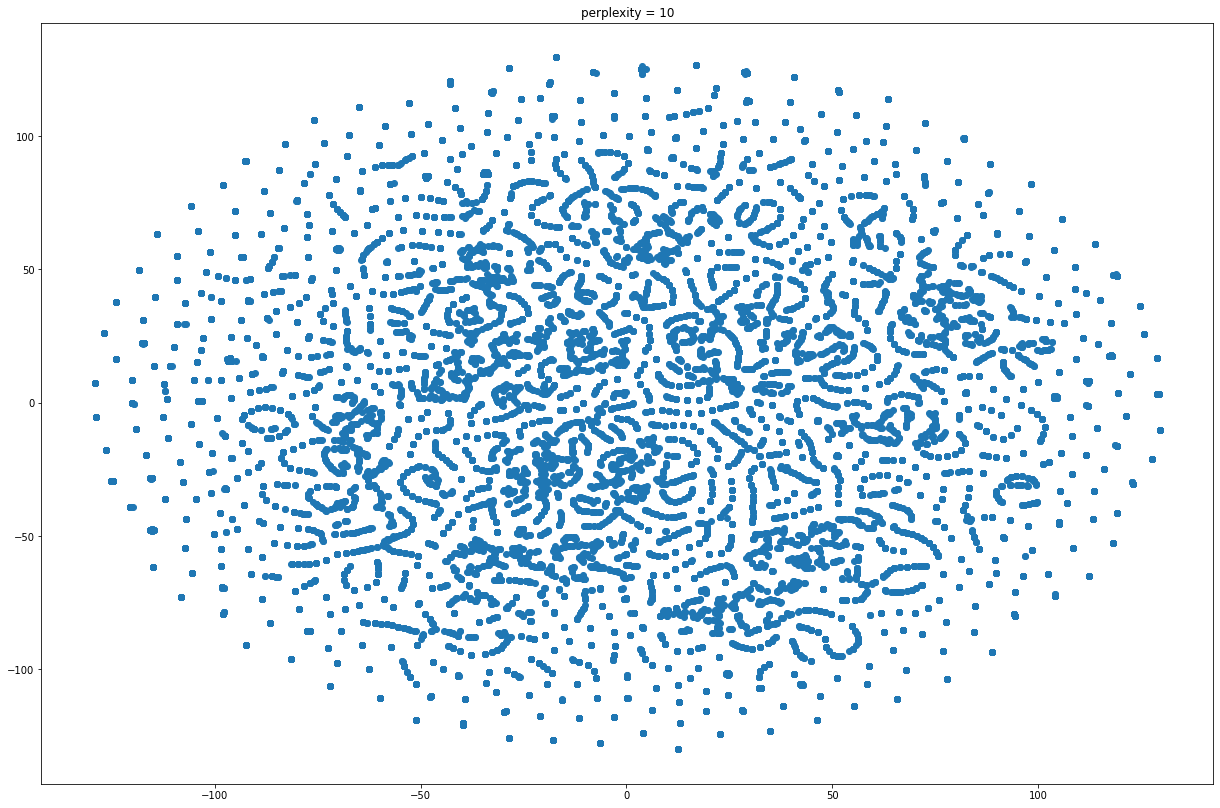

In [41]:
# Обучим модели для двух компонент, с гиперпараметром perplexity равным 10 и визуализируем результаты:

tsne = TSNE(n_components=2, perplexity=10, random_state=21)
tsne_representation = tsne.fit_transform(X)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])
plt.title('perplexity = 10')
plt.show()

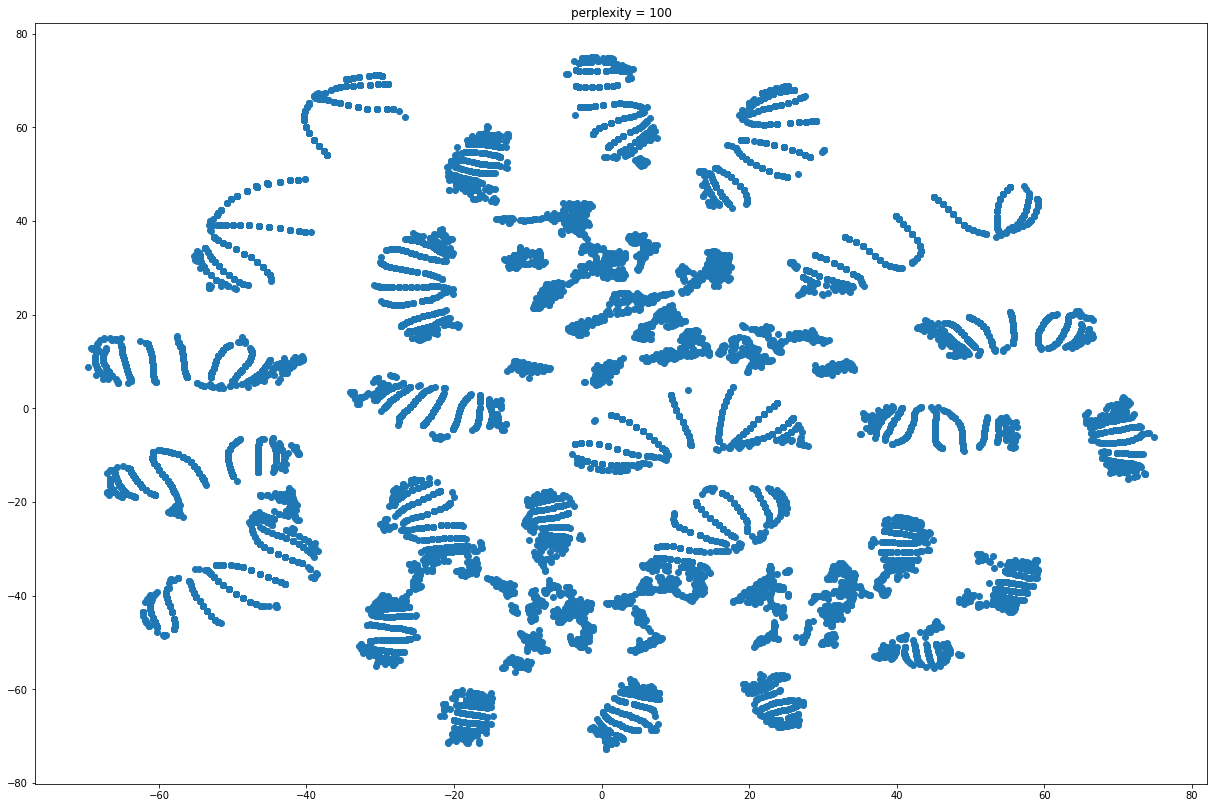

In [42]:
# Обучим модели для двух компонент, с гиперпараметром perplexity равным 100 и визуализируем результаты:

tsne = TSNE(n_components=2, perplexity=100, random_state=21)
tsne_representation = tsne.fit_transform(X)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])
plt.title('perplexity = 100')
plt.show()

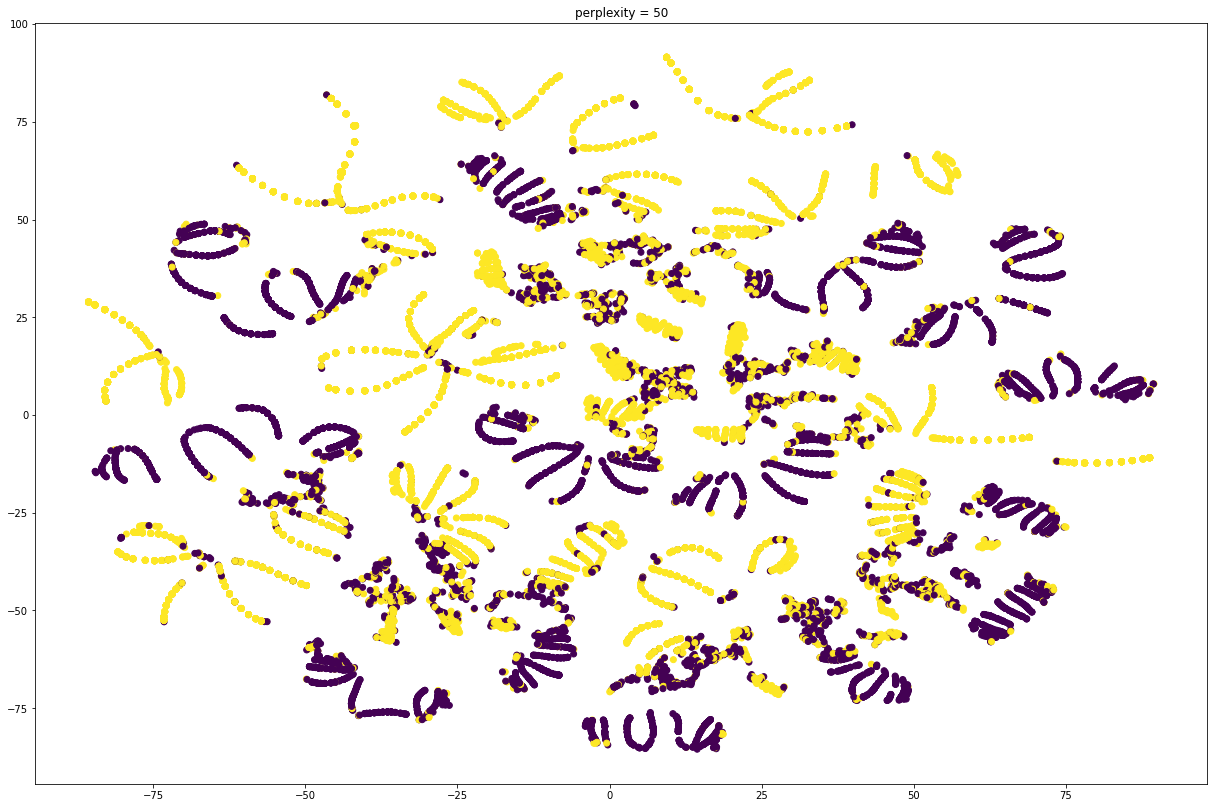

In [44]:
# Обучим модели для двух компонент, с гиперпараметром perplexity равным 50 и визуализируем результаты:

tsne = TSNE(n_components=2, perplexity=50, random_state=21)
tsne_representation = tsne.fit_transform(X)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y)
plt.title('perplexity = 50')
plt.show()

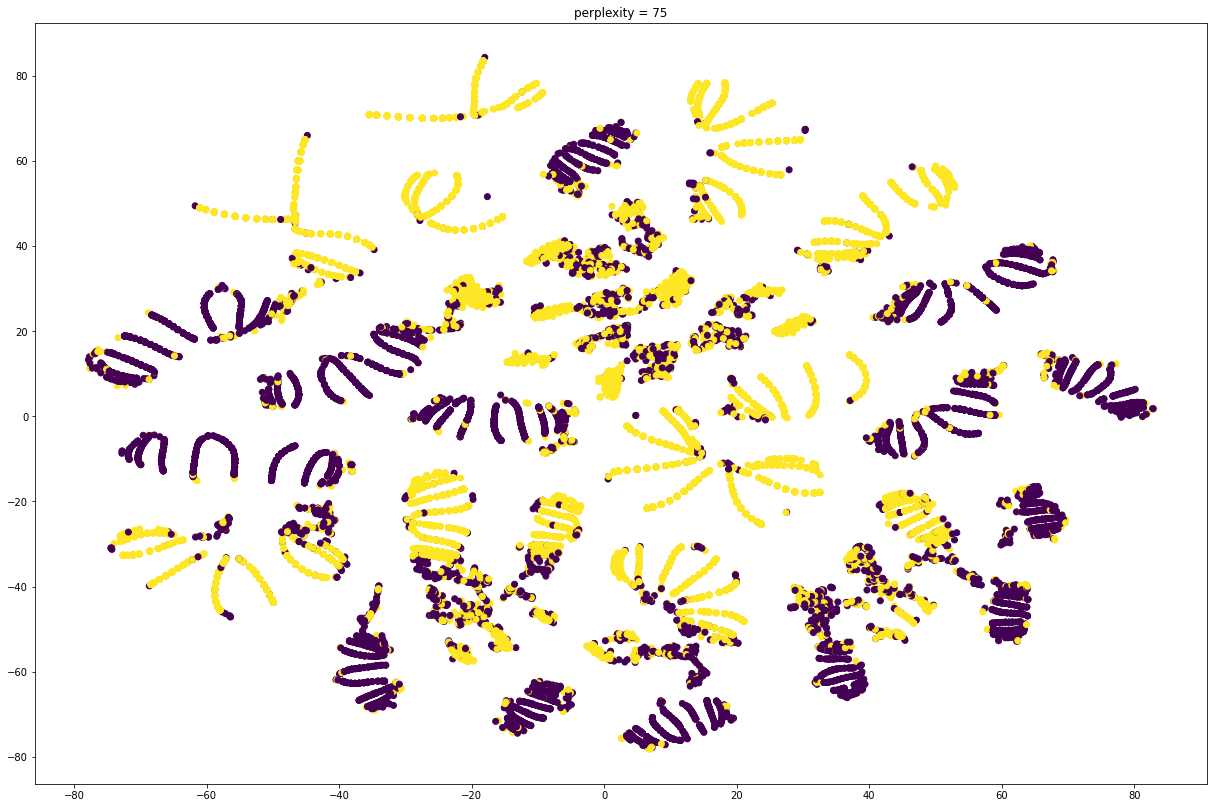

In [45]:
# Обучим модели для двух компонент, с гиперпараметром perplexity равным 75 и визуализируем результаты:

tsne = TSNE(n_components=2, perplexity=75, random_state=21)
tsne_representation = tsne.fit_transform(X)
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y)
plt.title('perplexity = 75')
plt.show()

Вывод. Увеличение параметра perplexity приводит к большей сгруппированности.

---

## DBSCAN

Еще один метод кластеризации - [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

Достоинства метода:

1. Самостоятельно определяет количество кластеров в зависимости от параметра eps.
2. Кроме кластеров определяет шум.
3. Работает с кластерами разной формы.

Недостатки метода:

1. С помощью метода невозможно проверить гипотезу о количестве кластеров, т.к. метод определяет их самостоятельно.
2. Необходим поиск параметра eps.
3. Не работает, если кластеры разной плотности.

---

# Задание 5

1. Заголовок последнего графика содержит ошибку "19 кластера". Необходимо написать функцию ***add_a_ov(n, word)***, которая поможет исправить ошибку. Функция обладает следующими характеристиками:
    - Функция получает на вход два параметра n и word:
        - n - числительное в виде целого числа; 
        - word - существительное мужского рода в единственном числе в именительном падеже.
    - Функция возвращает измененное word в соответствии с числительным n.
    - Примеры выполнения функции:
        - *add_a_ov(1, 'кластер')* вернет 'кластер';
        - *add_a_ov(2, 'кластер')* вернет 'кластера';
        - *add_a_ov(5, 'кластер')* вернет 'кластеров'.
        
        
2. Внесите изменения в функцию ***viz_dbscan()*** с учетом реализации функции ***add_a_ov(n, word)***.
3. Обучите модель DBSCAN с параметрами по умолчанию и визуализируйте результат.
4. Проведите поиск гиперпараметра ***eps***.
5. Проведите визуализацию зависимости количества кластеров от параметра ***eps***.
6. Обучите модель DBSCAN с таким параметром ***eps***, чтобы получить разбиение на два кластера.
7. Визуализируйте результат.
8. Проведите анализ соответствия полученных кластеров классам.
9. Оцените качество кластеризации и запишите результаты в таблицу.
10. Сделайте общий вывод по результатам кластеризации различными методами.

# РЕШЕНИЕ ЗАДАНИЯ 5

## Исправление функции viz_dbscan() 

Напишем функцию корректировки

In [46]:
def add_a_ov(n, word):
    n = n%100
    if n%10 in [2,3,4] and n//10 != 1:
        result = word + 'а'
    elif n%10 == 1 and n != 11:
        result = word
    else:
        result = word + 'ов'
    return result

Внесем изменения в функцию viz_dbscan()

In [47]:
def viz_dbscan(labels, x2d):
    clstr = []
    k = labels.min()
    if k == -1:
        title = ['DBSCAN нашел ', ' и шум']
    else:
        title = ['DBSCAN нашел ', '']
    for j in range(k, labels.max()+1):
        plt.scatter(x2d[labels==j, 0], x2d[labels==j, 1])
        if j == -1:
            clstr = ['Шум']
        else:
            clstr.append('Кластер '+str(j+1))
    plt.legend(clstr)
    word = add_a_ov(len(clstr)+k, 'кластер')
    plt.title(title[0] + str(len(clstr)+k) + ' ' + word+ title[1])
    plt.show()

## Обучение модель DBSCAN 

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
# Обучим модель с параметрами по умолчанию

dbscan = DBSCAN(eps=0.5)
dbscan.fit(X)

DBSCAN()

In [50]:
# Для отображения результатов на плоскости снизим размерность задачи с помощью t-SNE (в прошлой задаче мы вабрали perplexity = 75 как оптимальную)

tsne = TSNE(n_components=2, perplexity=75, random_state=21)
tsne_X = tsne.fit_transform(X)

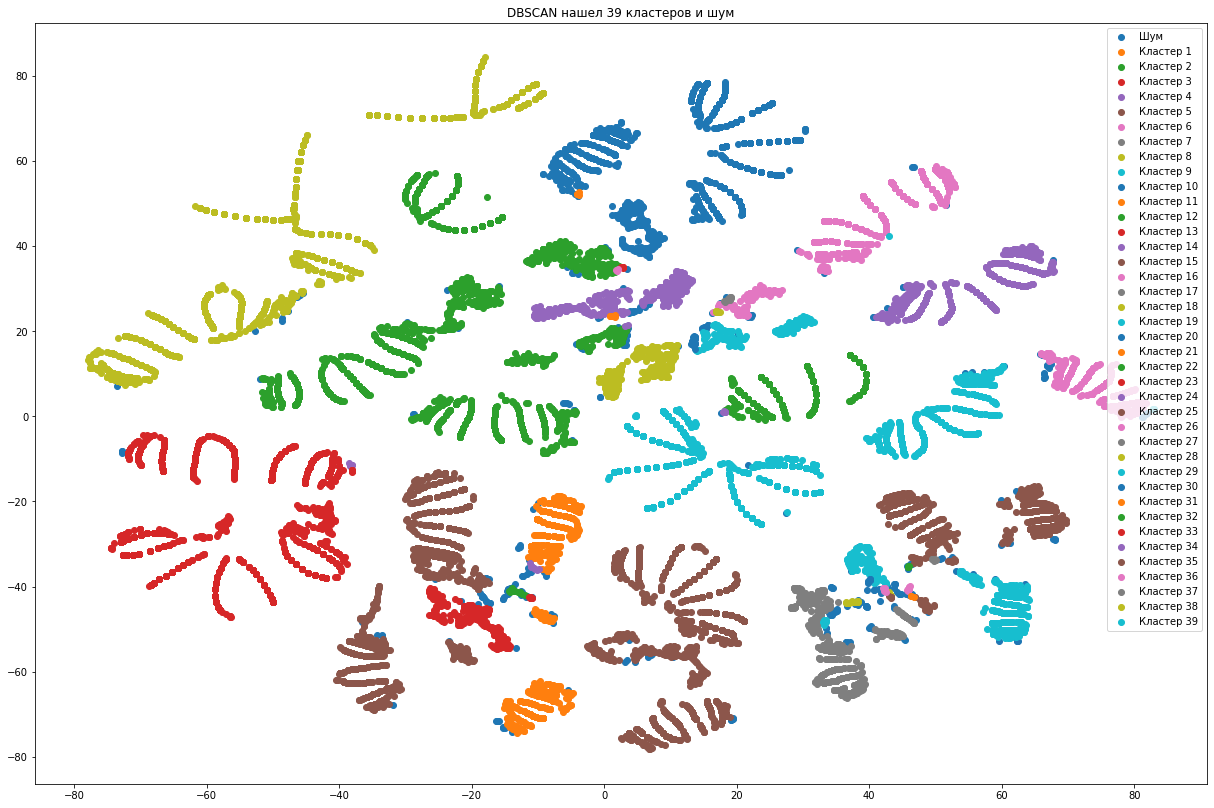

In [51]:
# Визуализируем результаты кластеризации

viz_dbscan(dbscan.labels_, tsne_X)

Выберем параметр ESP. Параметр eps по оси ординат необходимо выбрать так, чтобы после пересечения прямой с графиком, график шел вертикально вверх.

In [52]:
from sklearn.neighbors import NearestNeighbors

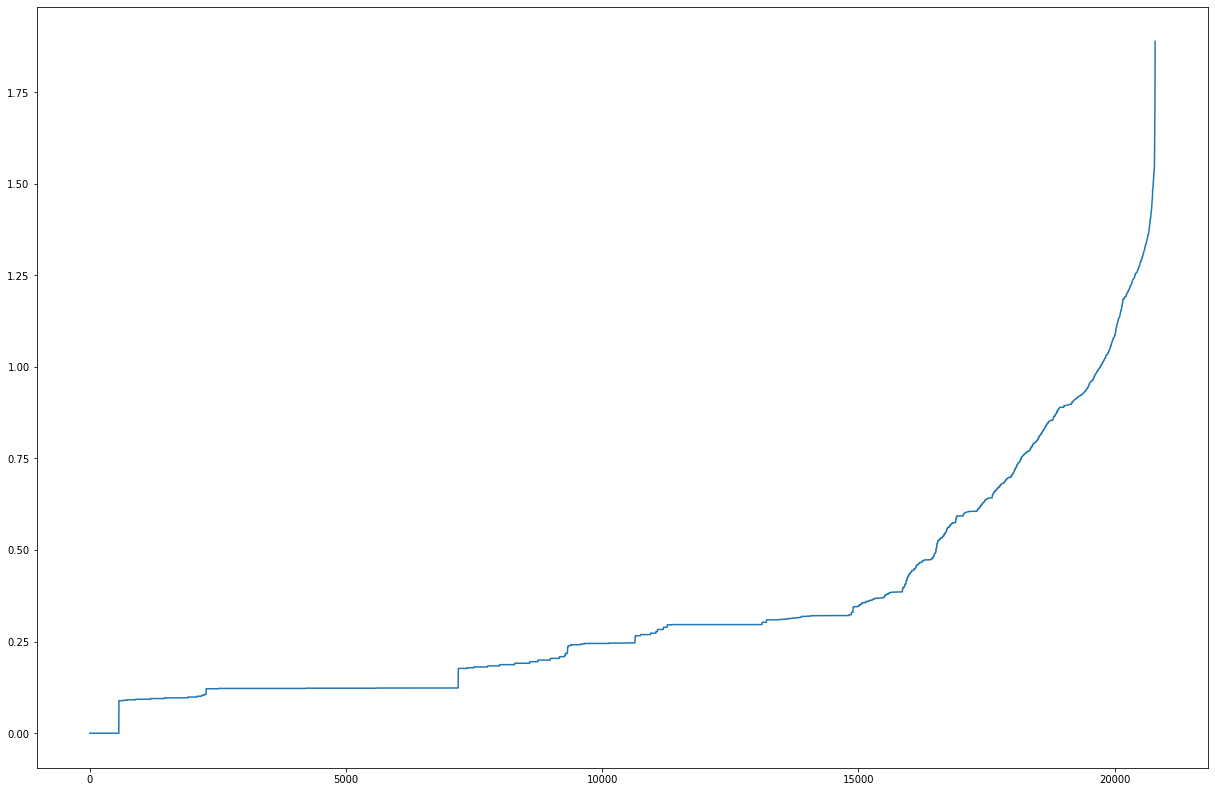

In [53]:
model_NN = NearestNeighbors(n_neighbors=25)
model_NN.fit(X)
dist, _ = model_NN.kneighbors(X, n_neighbors=25, return_distance=True)
dist = np.sort(dist[:,-1])
plt.plot(dist)
plt.show()

Можно посмотреть, при каких значениях eps сколько кластеров строит DBSCAN. Например, следующий код строит зависимость количества кластеров от eps, изменяющегося от 0.1 до 1.99:

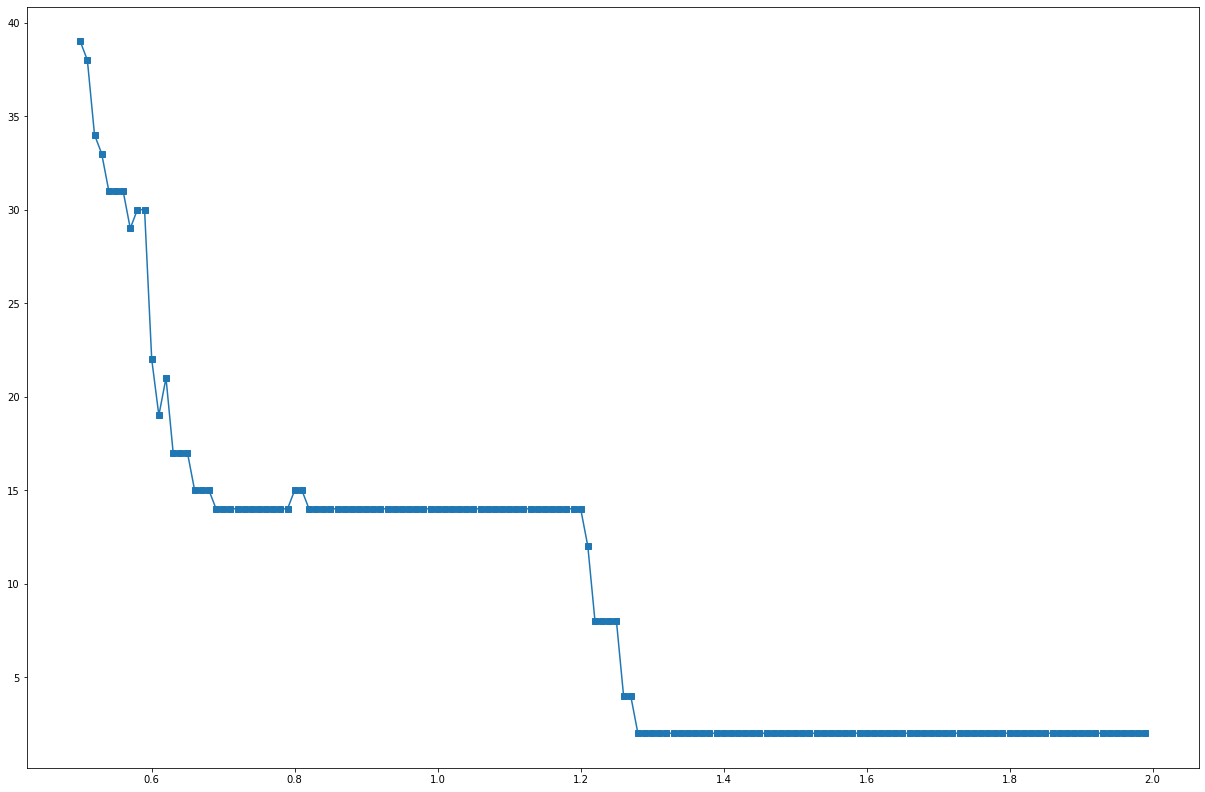

In [54]:
epsilon = []
n_claster = []
for j in range(50, 200, 1):
    dbscan = DBSCAN(eps=j/100)
    dbscan.fit(X)
    epsilon.append(j/100)
    n_claster.append(dbscan.labels_.max()+1)
plt.plot(epsilon, n_claster, marker='s')
plt.show()

Разбиение на два кластера будет при eps = 1.3. Применим найденный eps.

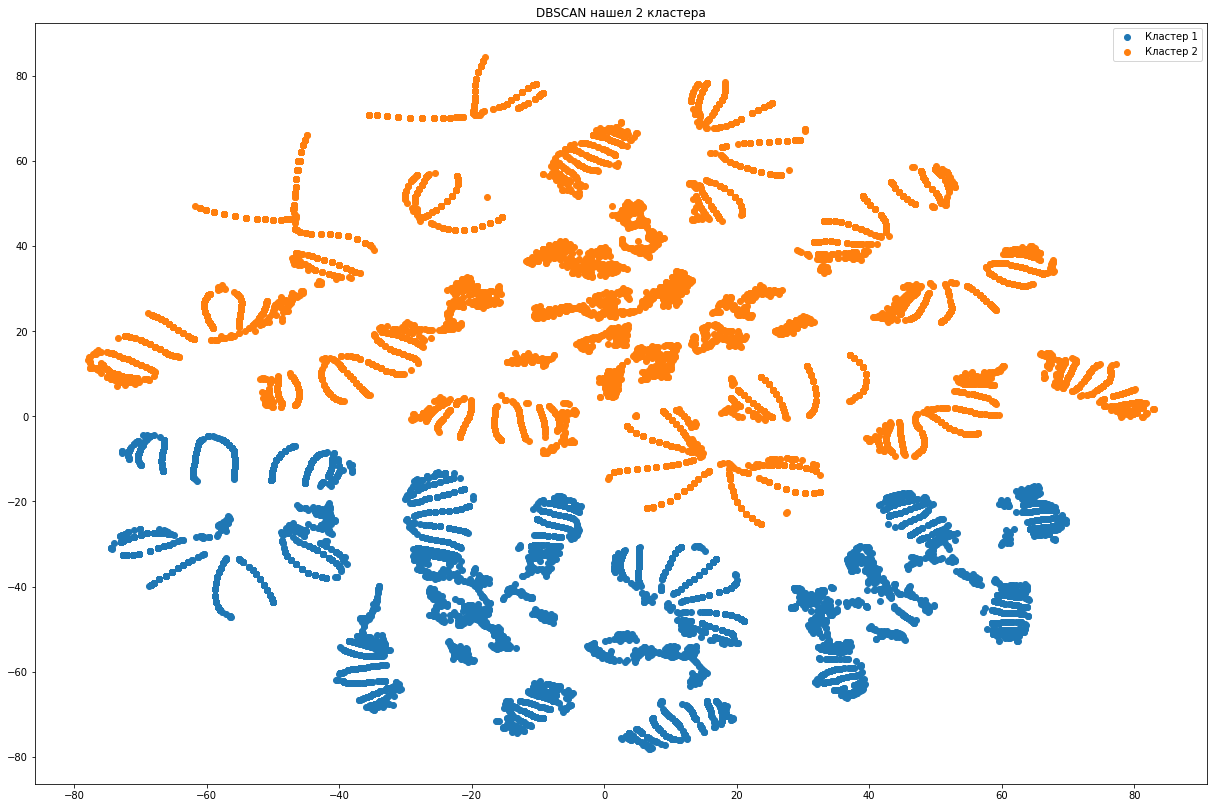

In [55]:
dbscan = DBSCAN(eps=1.3)
dbscan.fit(X)
viz_dbscan(dbscan.labels_, tsne_X)

Оценим качество кластеризации:

In [56]:
for j in range(dbscan.labels_.max()+1):
    print('метка класса =', j, '   метка кластера =', dbscan.labels_[y==j].mean(), 
          '   стандартное отклонение меток кластера =', dbscan.labels_[y==j].std())

метка класса = 0    метка кластера = 0.5475556502289913    стандартное отклонение меток кластера = 0.4977333223035182
метка класса = 1    метка кластера = 0.6455007893352044    стандартное отклонение меток кластера = 0.47836128637550973


In [57]:
print(classification_report(y_ac, dbscan.labels_))

              precision    recall  f1-score   support

         0.0       0.51      0.45      0.48      9389
         1.0       0.59      0.65      0.62     11402

    accuracy                           0.56     20791
   macro avg       0.55      0.55      0.55     20791
weighted avg       0.55      0.56      0.55     20791



In [58]:
m4['DBSCAN'] = metrics4(X, dbscan.labels_, y_ac)
m4

,KMeans,AgglomerativeClustering,DBSCAN
adjusted_rand_score,0.432206,0.589320,0.013180
silhouette_score,0.250400,0.223899,0.194839
calinski_harabasz_score,6832.006453,5819.019760,4462.031761
davies_bouldin_score,1.702163,1.787194,2.074507


Первые два метода показали примерно одинаковые значения метрик качества кластеризации. Последний метод показал совсем плохие результаты при делении на два кластера. Высокой точности модели мы не можем достичь из-за пересечения кластеров.

Для оценки качества полученного разбиения не обязательно применять метрики, достаточно взглянуть на процент данных, определенных как шум:

In [59]:
print('DBSCAN определил', str(len(dbscan.labels_[dbscan.labels_==-1])/10) +'%', 'данных как шум')

DBSCAN определил 0.0% данных как шум


DBSCAN определил 0% данных как шум

In [60]:
# код проверки правильности функции add_a_ov. Запустите его, чтобы узнать, правильно ли описана функция

def test(n, word):
    n = n%100
    if n%10 in [2,3,4] and n//10 != 1:
        result = word + 'а'
    elif n%10 == 1 and n != 11:
        result = word
    else:
        result = word + 'ов'
    return result


for j in [i for i in range(31)]+[101,102,105,111,112,1001,1002,1005,1011,1012,1021,1022]:
    if test(j, 'слон') != add_a_ov(j, 'слон'):
        break
if j < 1022:
    print(j, add_a_ov(j, 'слон'))
    if j < 10:
        print('Функция содержит критичные ошибки')
    elif j < 20:
        print('Функция содержит критичные ошибки. Не верно обрабатываются числительные от 11 до 14')
    elif j < 100:
        print('Функция содержит критичные ошибки. Не верно обрабатываются числительные от 20 до 100')
    elif j < 1000:
        print('Функция содержит не критичные для задачи ошибки.', 
              'Не верно обрабатываются числительные свыше 100')
    elif j >= 1000:
        print('Функция содержит не критичные для задачи ошибки.', 
              'Не верно обрабатываются числительные от 1000 и выше')
else:
    print('Функция работает нормально')

Функция работает нормально
